## Intro

EGG provides multiple components to create different types of games. In particular, EGG has strong tooling for creating one-step Sender/Receiver games. In these games, two agents, Sender and Receiver, are trained to perform a common task while following a simple communication protocol:

 * Sender receives an input (e.g., an image) and sends a single message to Receiver;
 * Receiver obtains the message and (optionally) its own input, produces an output.

This type of games includes, for instance, signaling games and discrete auto-encoders. In a nutshell, any Sender/Receiver game only differs in terms of (a) input data, (b) agents' architecture, (c) communication type (one-symbol, fixed-lentgh or variable-length multiple-symbol messages), (d) loss. EGG allows us to create new games by only specifying those components. 

In most cases, training of agents with discrete channel communication is done either via Gumbel-Softmax relaxation or by means of Reinforce. EGG allows to switch between the two with minimal changes in the logic.



## MNIST Auto-encoder game

In this  tutorial we will create a conceptually simple, but fully-featured Sender/Receiver game. In this game, Sender and Receiver are trained together such that Sender tries to encode a MNIST digit in a discrete message and Receiver will try to decode it from the message.

While implementing this game, we will walk through several steps, typical for creating a new game:
 * pre-train a _vision_ module for the Sender agent by training it to classify digits;
 * use the pre-trained vision module to implement Sender and Receiver that communicate via a single symbol messages and analyse the trained models;
 * update the agents to allow variable-length multi-symbol messages.

NB: depending on the computational resources you have available, this might be slow to run. To get at least a sense of the full pipeline, consider reducing the number of training epochs, or, alternatively, run a Google Colab version of the tutorial using a GPU.

So let's start!

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2


import torch
import torch.nn as nn
import egg.core as core

from torchvision import datasets, transforms
from torch import nn
from torch.nn import functional as F

import matplotlib.pyplot as plt
import random
import numpy as np

from pylab import rcParams
rcParams['figure.figsize'] = 5, 10

# For convenince and reproducibility, we set some EGG-level command line arguments here
opts = core.init(params=['--random_seed=7', # will initialize numpy, torch, and python RNGs
                         '--lr=1e-3',   # sets the learning rate for the selected optimizer 
                         '--batch_size=32',
                         '--optimizer=adam'])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In most cases, we want to start a script by initializing EGG by calling `core.init` Typically, we use command-line arguments for that (see https://github.com/fairinternal/EGG/blob/master/egg/core/CL.md for more details)

Next, we implement our ```Vision``` module (a part of a standard MNIST [model](https://github.com/pytorch/examples/blob/master/mnist/main.py)) that maps a MNIST image into a 500-dimensional vector.
To pre-train this ```Vision``` module, we'll use the auxilary task of classifying MNIST digits. For this, we also define a ```PretrainNet``` model that takes the output of ```Vision``` and classifies images into 10 classes (0, 1, ..., 9).

In [3]:
class Vision(nn.Module):
    def __init__(self):
        super(Vision, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        return x

class PretrainNet(nn.Module):
    def __init__(self, vision_module):
        super(PretrainNet, self).__init__()
        self.vision_module = vision_module
        self.fc = nn.Linear(500, 10)
        
    def forward(self, x):
        x = self.vision_module(x)
        x = self.fc(F.leaky_relu(x))
        return x

We also need DataLoaders for MNIST....

In [4]:
kwargs = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {}
transform = transforms.ToTensor()

batch_size = opts.batch_size # set via the CL arguments above
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=True, download=True,
           transform=transform),
           batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('./data', train=False, transform=transform),
           batch_size=batch_size, shuffle=False, **kwargs)

Now, everything is ready to actually run the pre-training. First, we instantiate the modules and then run 10 epochs of MNIST digit recognition by a PretrainNet instance:

In [5]:
vision = Vision()
class_prediction = PretrainNet(vision) #  note that we pass vision - which we want to pretrain
optimizer = core.build_optimizer(class_prediction.parameters()) #  uses command-line parameters we passed to core.init
class_prediction = class_prediction.to(device)

Now we can run very typical Pytorch training loop to pretrain the vision module:

In [6]:
for epoch in range(10):
    mean_loss, n_batches = 0, 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = class_prediction(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        mean_loss += loss.mean().item()
        n_batches += 1
        
    print(f'Train Epoch: {epoch}, mean loss: {mean_loss / n_batches}')

/nix/store/sydq1qsriw0iqc3541k0zx3qdgjizii7-devenv-profile/lib/python3.12/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /build/pytorch/aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


Train Epoch: 0, mean loss: 0.1214693161662668
Train Epoch: 1, mean loss: 0.04112200490600662
Train Epoch: 2, mean loss: 0.028809826462869146
Train Epoch: 3, mean loss: 0.019593447638084883
Train Epoch: 4, mean loss: 0.01707266856304814
Train Epoch: 5, mean loss: 0.012843565730999458
Train Epoch: 6, mean loss: 0.010465325219307011
Train Epoch: 7, mean loss: 0.010704872292693436
Train Epoch: 8, mean loss: 0.008285486291986843
Train Epoch: 9, mean loss: 0.007974196287925304


Awesome! Now ```vision``` is a pre-trained ```Vision``` module and we can proceed to actually implement the communication game.

## Single-symbol communication

As said before, Sender/Receiver games only differ in the data used, the architecture of the agents, the type of the channel, and the loss.
We will start with the simplest communication case, one-symbol communication.


Let's define our Sender (that will re-use the pre-trained ```vision``` module) and Receiver. 
For implementing single-symbol games, EGG provides special wrappers, ```GumbelSoftmaxWrapper``` and ```ReinforceWrapper``` that wrap an agent and implement the required Gumbel-Softmax or Reinforce-specific logic. Both wrappers assume that the agent returns log-probabilities over all terms for the vocabulary.

We start by defining the logic of our agents:

In [7]:
class Sender(nn.Module):
    def __init__(self, vision, output_size):
        super(Sender, self).__init__()
        self.fc = nn.Linear(500, output_size)
        self.vision = vision
        
    def forward(self, x, aux_input=None):
        with torch.no_grad():
            x = self.vision(x)
        x = self.fc(x)
        return x
    
    
class Receiver(nn.Module):
    def __init__(self, input_size):
        super(Receiver, self).__init__()
        self.fc = nn.Linear(input_size, 784)

    def forward(self, channel_input, receiver_input=None, aux_input=None):
        x = self.fc(channel_input)
        return torch.sigmoid(x)

sender = Sender(vision, output_size=400)
receiver = Receiver(input_size=400)

While ```GumbelSoftmaxWrapper``` and ```ReinforceWrapper``` have the same interface to the user's defined Sender and Receiver, they do differ in their output.

Since ```GumbelSoftmaxWrapper``` uses relaxation of the symbols, it doesn't output the index of the used symbol; instead, it outputs a tensor of dimensions (batch size; vocab size) with potentially all elements being non-zero. In evaluation mode, it outputs a tensor of the same dimensionality, but with the one-hot encoded symbol of highest probability. In contrast, ```ReinforceWrapper``` directly outputs the index of the transmitted symbol (plus other data to be discussed below). 

To make the change of wrappers simpler, we define a special helper layer, `core.RelaxedEmbedding` which behaves as a standard `torch.nn.Embedding` layer if the inputs are indexes (i.e. are of type torch.long), or provides their relaxation, if they are a tensor of floats. You don't have to use this, but it makes changing the training from GS-based to RF-based and vice-versa very simple, because you do not need to worry about the type of the input that the Receiver will get.

Furthermore, you can also wrap your Receiver agent logic in the `core.SymbolReceiverWrapper`. This wrapper would embed the input symbol via the `core.RelaxedEmbedding` and pass the resulting embedding to the user-implement agent.

(NB: `core.RelaxedEmbedding` has the same initialization as `torch.nn.Embedding` - different from that of `nn.Linear`!)

Apart from specifying the agents' architecture, we have to define the loss that the agents experience. By default, EGG expects the loss function to take the following arguments: Sender's input, the message transmitted, the input of the receiver, the output of the receiver, and the labels provided from the dataset. 
Any of those can be used or ignored. In the case of our MNIST auto-encoder game, there is no specific input for Receiver, so the game mechanics passes `None` instead.

In [8]:
def loss(sender_input, _message, _receiver_input, receiver_output, _labels, _aux_input=None):
    loss = F.binary_cross_entropy(receiver_output, sender_input.view(-1, 784), reduction='none').mean(dim=1)
    return loss, {}

Note that this loss function is differentiable; it doesn't have to be differentiable if the training is done via Reinforce. However, if it is the case, the training of Receiver might be able to exploit that. See the [readme](https://github.com/facebookresearch/EGG/blob/master/README.md#an-important-technical-point) for more discussion.

Another common parameter that would be shared across all the games we'll implement is the size of the vocabulary. We set it to 10 as MNIST has 10 digits; although it might be fun to play with other values.

In [9]:
vocab_size = 10

### Training with Gumbel-Softmax

The next step is to actually create the agents. We first discuss how training can be done with Gumbel-Softmax. For that, we instantiate our Sender and Receiver and wrap Sender into `core.GumbelSoftmaxWrapper`.

In [10]:
sender = Sender(vision, vocab_size)
sender = core.GumbelSoftmaxWrapper(sender, temperature=1.0) # wrapping into a GS interface, requires GS temperature
receiver = Receiver(input_size=400)
receiver = core.SymbolReceiverWrapper(receiver, vocab_size, agent_input_size=400)


Once we have the agents created, we can adopt a pre-defined game logic which juggles the agents, messages, 
data, and the loss. Essentially, the game instance is also a `torch.nn.Module` - hence it can be handled as that, i.e.
we can extract the trainable parameters of the agents, push it around devices, etc. Each game is expected to output a two-tuple. The first element of the tuple is a loss that is to be minimized. The second is a python dict `{}` of some auxilary values that are averaged over the epoch and printed. Accuracy or entropy of the communication channel are good examples of such auxilary data.


Another entity that we will need is `core.Trainer`. Essentially, `Trainer` implements the training loop, handles checkpointing, etc.


The Gumbel-Softmax distribution is parameterised by its temperature. In general, the latter has strong impact on training. To anneal the temperature of Sender, we create a callback that `trainer` invokes after each training epoch is over. In this snippet, the callback applies a multiplicative decay rule on the temperature value.

In [11]:
game = core.SymbolGameGS(sender, receiver, loss)
optimizer = torch.optim.Adam(game.parameters())

trainer = core.Trainer(
    game=game, optimizer=optimizer, train_data=train_loader,
    validation_data=test_loader, callbacks=[core.TemperatureUpdater(agent=sender, decay=0.9, minimum=0.1)]
)

Yay, everything is ready for actual training!

In [12]:
n_epochs = 15
trainer.train(n_epochs)

Now when Sender and Receiver are trained, we firstly have a look at the codebook they came up with: what does Receiver output when given a particular word from a vocabulary? For that, we'll take every word in the vocabulary [0..9], wrap it into a tensor and pass it to Receiver:

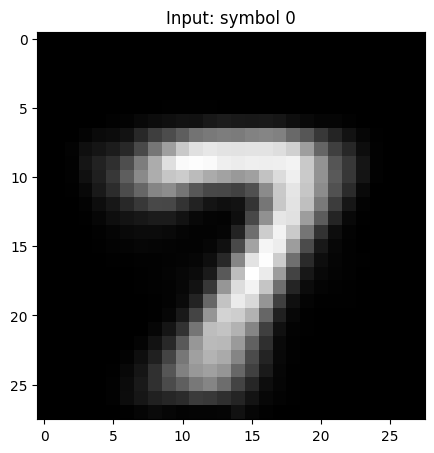

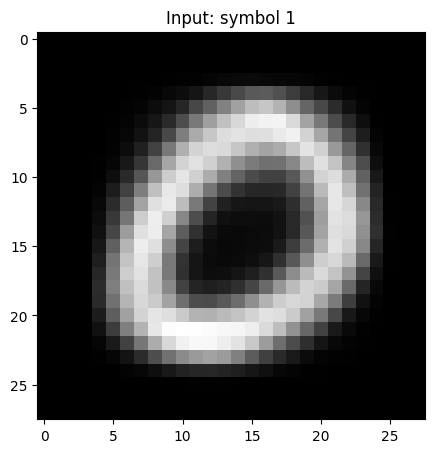

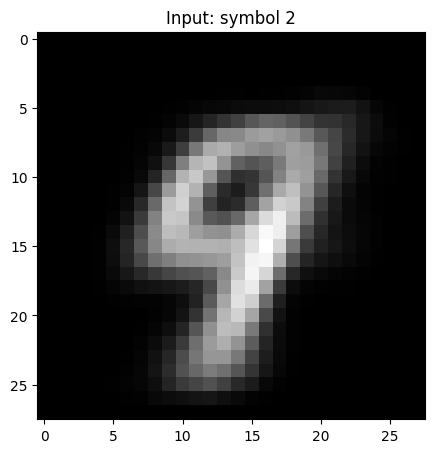

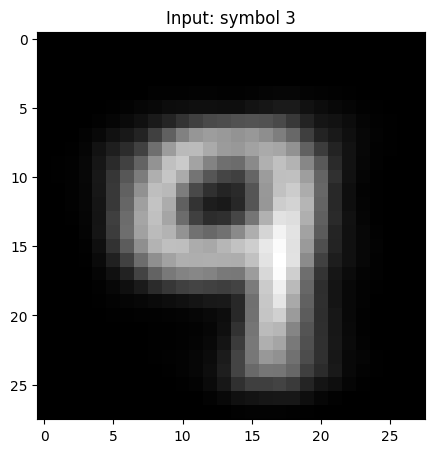

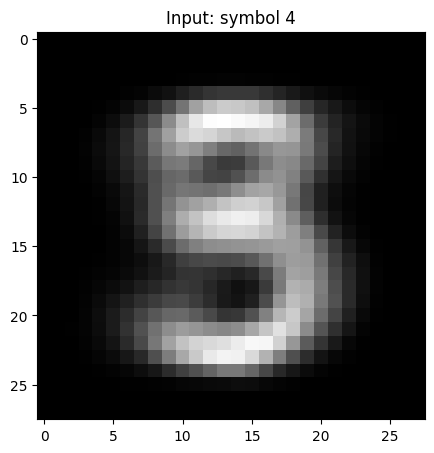

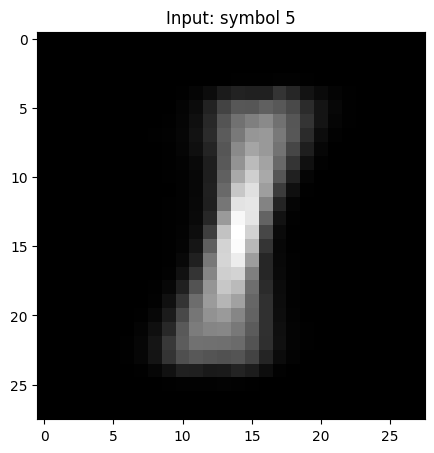

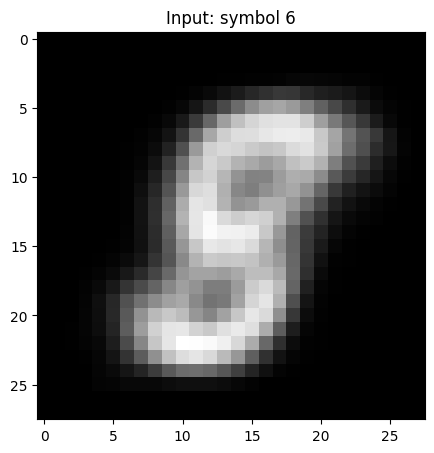

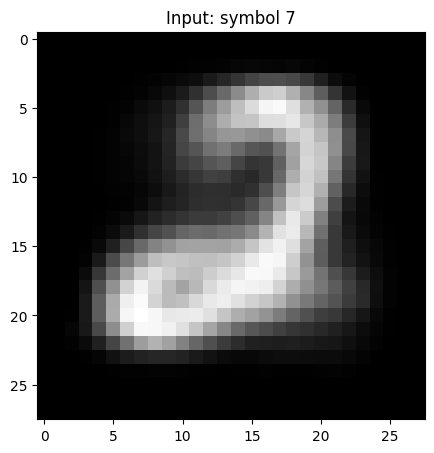

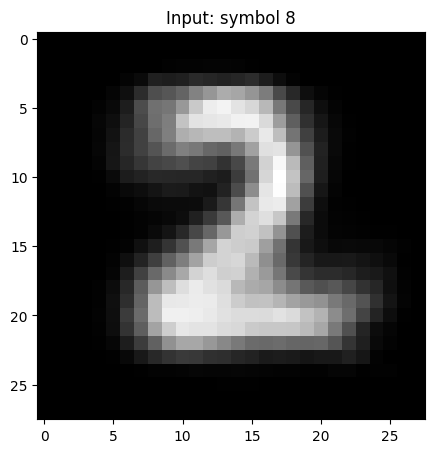

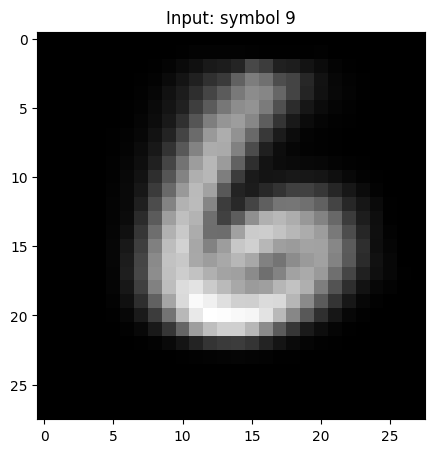

In [13]:
game.eval()

for z in range(vocab_size):
    t = torch.zeros(vocab_size).to(device)
    t[z] = 1
    with torch.no_grad():
        # Receiver outputs a single tensor of predictions
        sample = game.receiver(t).float().cpu()
    sample = sample.view(28, 28)
    plt.title(f"Input: symbol {z}")
    plt.imshow(sample, cmap='gray')
    plt.show()

Ok, not too bad: some digits are vague, but others do resemble actual digits. Huh!


Next, how good are our two agents at auto-encoding the images? Let's take some images from the validation set, feed them to Sender and look at (a) what messages are sent, (b) how does Receiver's output look like?

First, we define a tiny, single-batch 10-digit test dataset:

In [14]:
test_inputs = []
for z in range(10):
    index = (test_loader.dataset.targets[:100] == z).nonzero()[0, 0]
    img, _ = test_loader.dataset[index]
    test_inputs.append(img.unsqueeze(0))
test_inputs = torch.cat(test_inputs)

test_dataset = [[test_inputs, None]]

Next, we write a small helper function to dump and plot the input-outputs of the agents along with the communicated messages. We will use it throughout the tutorial.

In [15]:
def plot(game, test_dataset, is_gs, variable_length):
    interaction = \
            core.dump_interactions(game, test_dataset, is_gs, variable_length)

    for z in range(10):
        src = interaction.sender_input[z].squeeze(0)
        dst = interaction.receiver_output[z].view(28, 28)
        # we'll plot two images side-by-side: the original (left) and the reconstruction
        image = torch.cat([src, dst], dim=1).cpu().numpy()

        plt.title(f"Input: digit {z}, channel message {interaction.message[z]}")
        plt.imshow(image, cmap='gray')
        plt.show()

Here the left image is the original and the one on the right is the recovered one, each pair is labelled by the original class and the symbol sent over the channel.

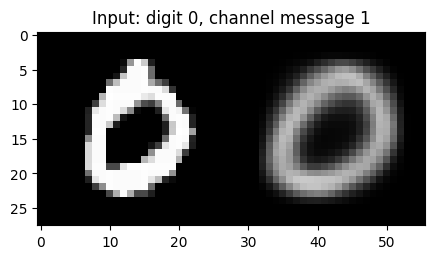

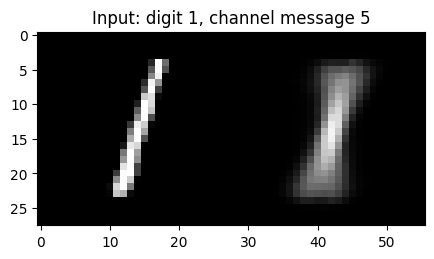

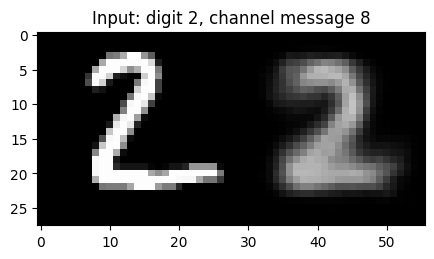

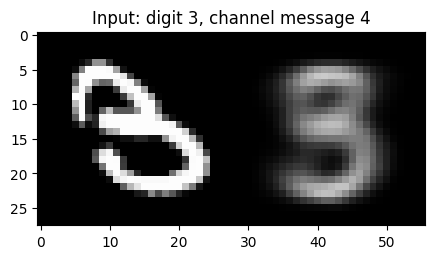

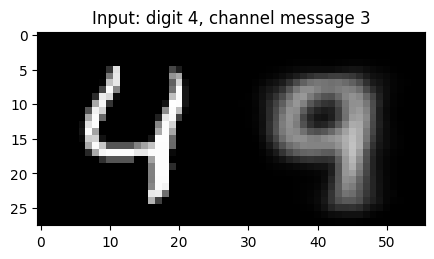

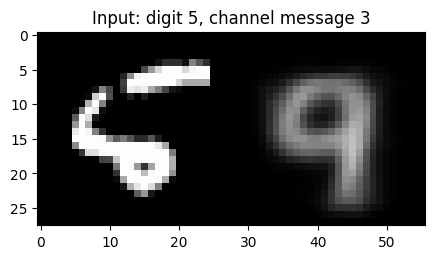

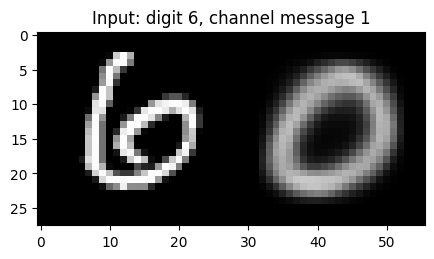

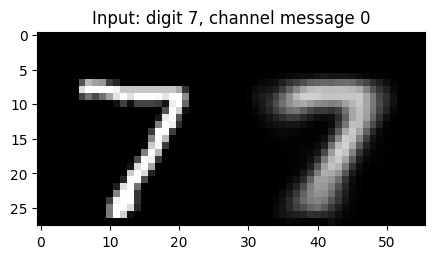

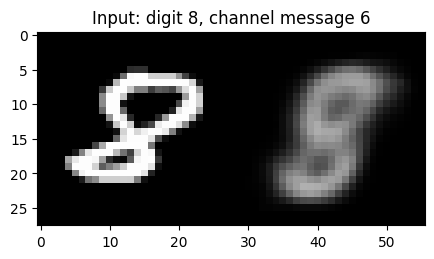

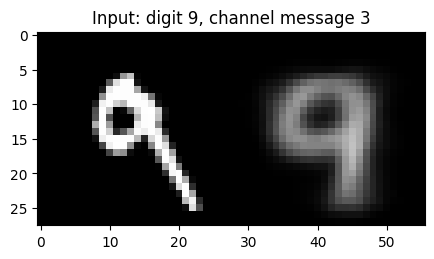

In [16]:
plot(game, test_dataset, is_gs=True, variable_length=False)

Again, not totally unreasonable! 

### Training with Reinforce
What's the equivalent code when training by Reinforce?

We create exactly the same Sender instance, but then feed it into ```core.ReinforceWrapper```. This wrapper implements the boilerplate code required for Reinforce-based optimization: samples from a distribution, records the log-probability of what was sampled, and reports the entropy of the distribution (*).

Hence, each agent returns a tuple of three elements: the actual sampled output, the log-probability of the sampled output, and the entropy of the sampling distribution. During the evaluation, the sampling process is replaced by taking the most likely output.

But what if an agent (e.g. Receiver) runs a deterministic function? In that case, we use a simple `core.ReinforceDeterministicWrapper` that appends zero entropy and log-probability tensors. `ReinforceDeterministicWrapper` can only be used if Receiver's parameters can be optimized via a gradient-based optimization, i.e. the loss function has to be differentiable.



(*) Entropy regularization is used to encourage the agents to do some exploration.

In [17]:
sender = Sender(vision, output_size=vocab_size)
sender = core.ReinforceWrapper(sender)  # wrapping into a Reinforce interface

receiver = Receiver(input_size=400)
receiver = core.SymbolReceiverWrapper(receiver, vocab_size, agent_input_size=400)
receiver = core.ReinforceDeterministicWrapper(receiver)

This time we use the one-symbol game implementation with Reinforce logic, `core.SymbolGameReinforce`. It also consumes two entropy regularization terms, for Sender and Receiver. The entropies of the output distributions of the agents are weighted by these parameters and added to the loss.

Note that we managed to change from Gumbel Softmax to Reinforce training by only (a) changing the agent wrappers, (b) changing the game type.

In [18]:
game = core.SymbolGameReinforce(sender, receiver, loss, sender_entropy_coeff=0.05, receiver_entropy_coeff=0.0)
optimizer = torch.optim.Adam(game.parameters(), lr=1e-2) #  we can also use a manually set optimizer

trainer = core.Trainer(game=game, optimizer=optimizer, train_data=train_loader,
                           validation_data=test_loader)

In [19]:
n_epochs = 15
trainer.train(n_epochs)

Now let's check what is in the communication code book and the quality of the auto-encoding. The dumping code is essentially the same as before, the only change is that Receiver returns a tuple of three elements, and we need only one.

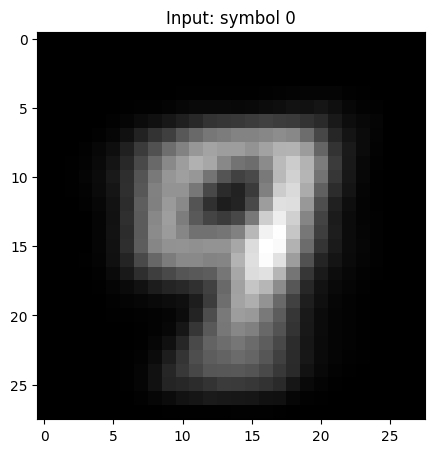

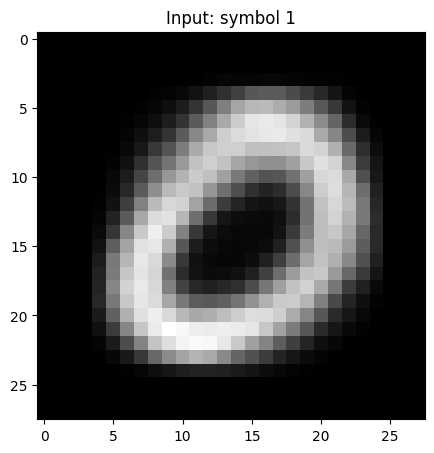

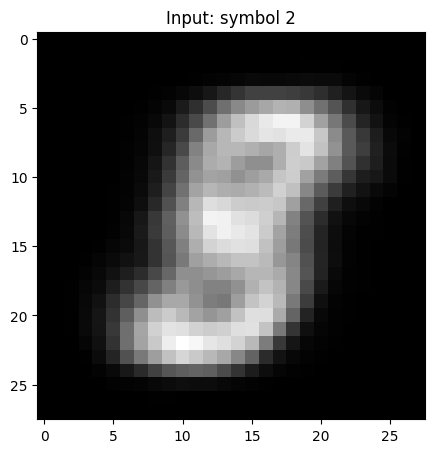

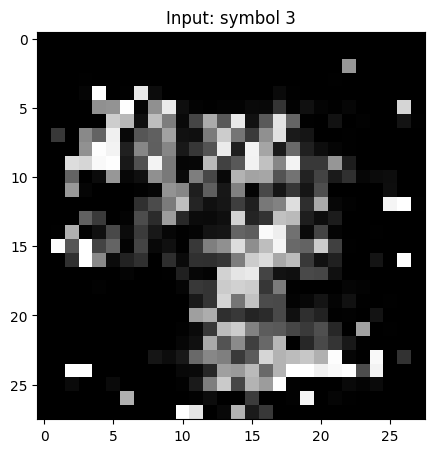

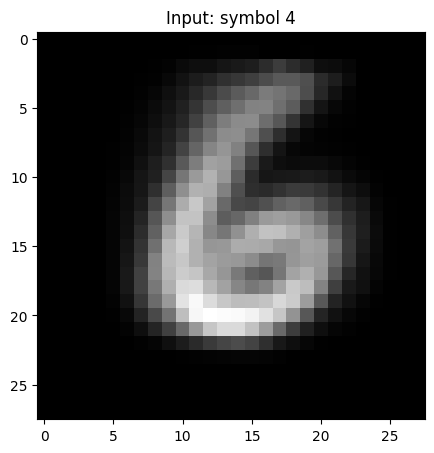

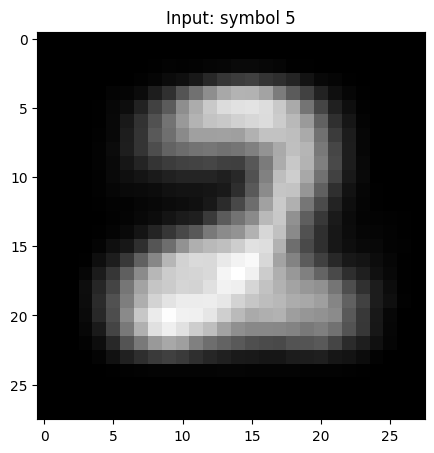

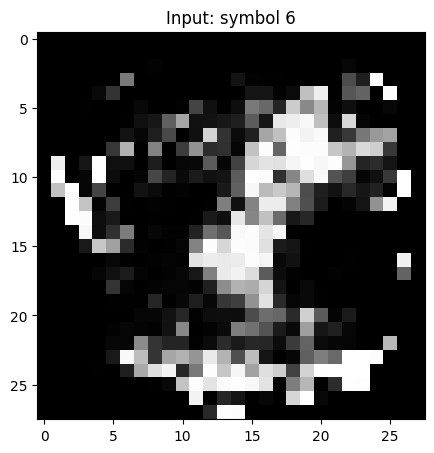

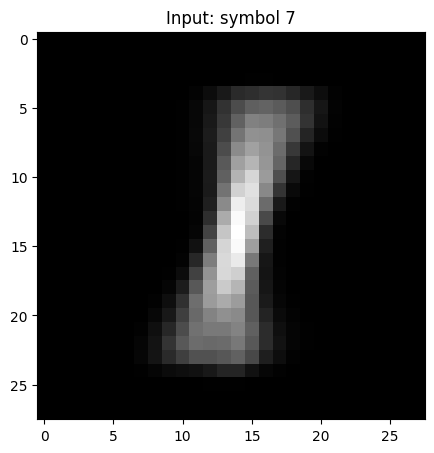

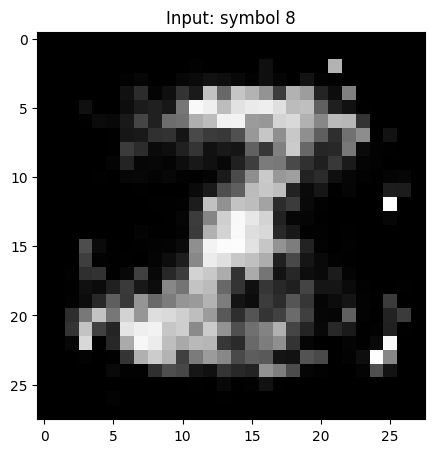

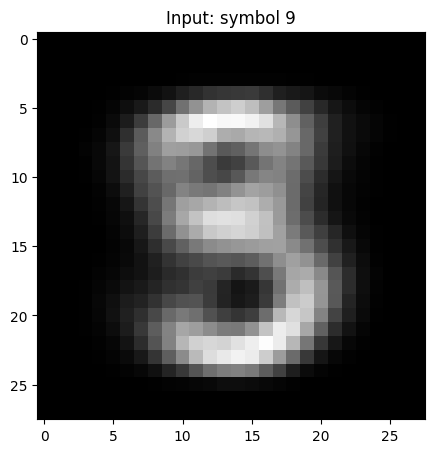

In [20]:
game.eval()

for z in range(vocab_size):
    t = torch.zeros(vocab_size).to(device)
    t[z] = 1
    with torch.no_grad():
        sample, _1, _2 = game.receiver(t)
        sample = sample.float().cpu()
    sample = sample.view(28, 28)
    plt.title(f"Input: symbol {z}")
    plt.imshow(sample, cmap='gray')
    plt.show()

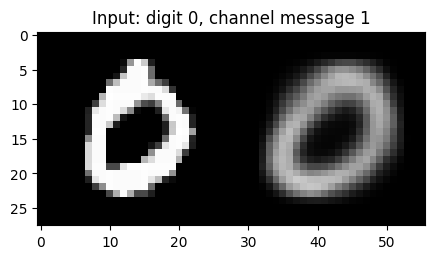

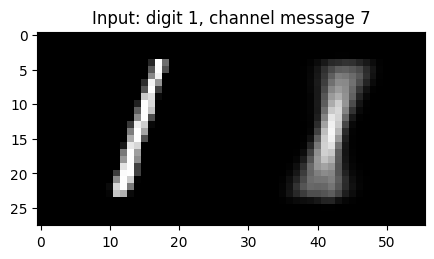

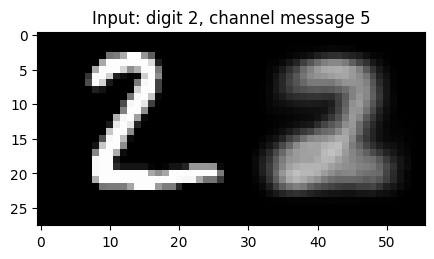

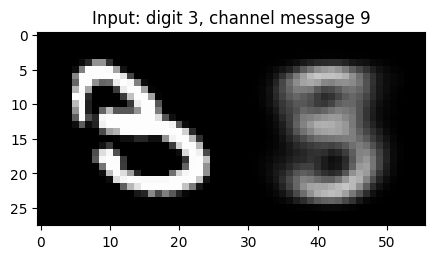

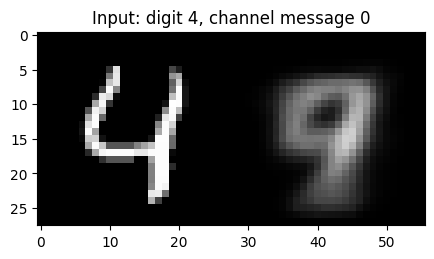

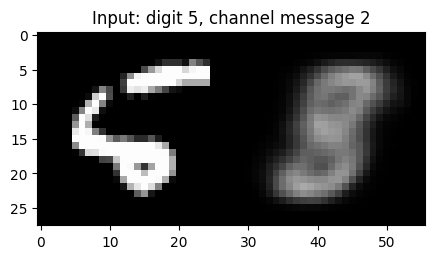

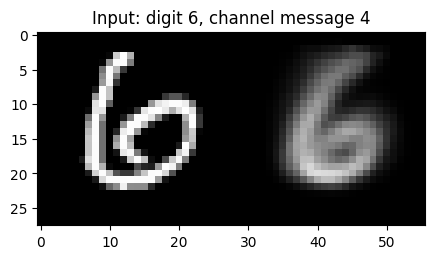

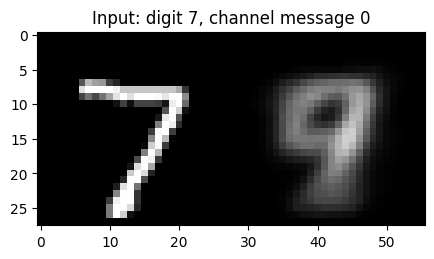

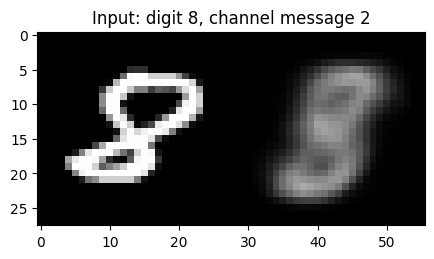

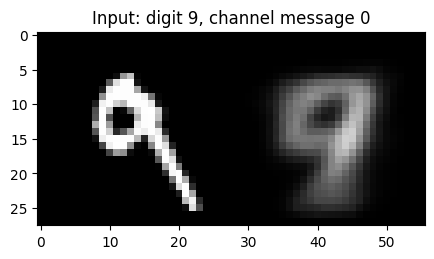

In [21]:
plot(game, test_dataset, is_gs=False, variable_length=False)

Not too bad either! Let us move to a more interesting case: variable-length messages. 

## Communication with variable-length messages

This time, communication is carried out by RNNs. EGG provides pre-implemented code to use vanilla RNNs, GRUs, or LSTMs. There is also an experimental support for communication via Transformer-based blocks.

 Note that, when communicating over variable-length sequences, we need to define a special end-of-sequence symbol. The agents are trained such that the loss is calculated wrt to the Receiver output either after receiving the end-of-sequence symbol or after the maximal number of symbols were produced. EGG handles those scenarios, by defining special wrappers for agents, RnnSenderGS and RnnReceiverGS for Gumbel Softmax-based learning, and RnnSenderReinforce and RnnReceiverReinforce for Reinforce-based learning.

By convention, the user-implemented Sender, after processing its input, outputs the initial hidden state vector for its RNN. EGG unrolls this RNN to produce a message. In turn, this message is fed into Receiver's RNN. The only thing that we need to implement for Receiver is how we map the Receiver RNN's hidden state to the Receiver's output.

**Important points concerning end-of-sequence behaviour: (1) EGG assumes that the end-of-sequence symbol is always 0. (2) `vocab_size` always includes the end-of-sequence symbol - hence `vocab_size=2` specifies the unary encoding. (3) Communication stops immediately if the first symbol emitted by Sender is 0.**

This time we'll have to specify some additional parameters:

In [22]:
# we start by defining the RNN parameters
hidden_size = 20
emb_size = 10

We will use the same pre-trained vision module. Note, this time **Sender does not output a vector which will be casted as logits of probabilities over the vocab - it only outputs the initial hidden state for its RNN cell**!

The rest is pretty much the same as before: we instantiate the instances and put them into wrappers (note that we set the RNN cell types to 'rnn' and maximal communication length `max_len=2`!)

First, we'll go through Gumbel Softmax-based training.


### Variable-length messages with Gumbel Softmax

In [23]:
sender = Sender(vision, hidden_size)
receiver = Receiver(hidden_size)

sender_rnn = core.RnnSenderGS(sender, vocab_size, emb_size, hidden_size,
                                   cell="gru", max_len=2, temperature=1.0)
receiver_rnn = core.RnnReceiverGS(receiver, vocab_size, emb_size,
                    hidden_size, cell="gru")

game_rnn = core.SenderReceiverRnnGS(sender_rnn, receiver_rnn, loss)

Note that sometimes specifying different learning speeds for the two agents aids learning; this can be done as follows

In [24]:
optimizer = torch.optim.Adam([
        {'params': game_rnn.sender.parameters(), 'lr': 1e-3},
        {'params': game_rnn.receiver.parameters(), 'lr': 1e-2}
    ])

Now we can train the agents

In [25]:
trainer = core.Trainer(game=game_rnn, optimizer=optimizer, train_data=train_loader,
                           validation_data=test_loader)
trainer.train(15)

Heh, the validation loss is lower than it used to be with one symbol communication. Let's see how it works. Again, the original image is on the left, the transmitted and decoded - on the right. The communicated message is in the title. Note that since default `vocab_size` is 10 and 0 is used for end-of-sequence, Sender has an effective vocabulary of 9 symbols.


In [26]:
plot(game_rnn, test_dataset, is_gs=True, variable_length=True)

RuntimeError: shape '[28, 28]' is invalid for input of size 2352

Seems to work better than with length-one!
 
We can also enumerate all possible 10x10 messages of length two {x = first symbol, y = second symbol} and check the Receiver's interpretation of the code, as shown next. NB: When x=0, the second symbol is ignored, as 0 is interpreted as end-of-sequence. For this reason, in this case Receiver generates the same image irrespective of y's value.

In [ ]:
f, ax = plt.subplots(10, 10, sharex=True, sharey=True)

for x in range(10):
    for y in range(10):
            
        t = torch.zeros((1, 2, vocab_size)).to(device)
        t[0, 0, x] = 1
        t[0, 1, y] = 1

        with torch.no_grad():
            sample = game_rnn.receiver(t).float().cpu()
            # 0 is the end-of-sequence symbol, hence we stop immediately when x == 0
            output_index = (0 if x == 0 else 1)
            sample = sample[0, output_index, :].view(28, 28)
            ax[x][y].imshow(sample, cmap='gray')
            
            if y == 0:
                ax[x][y].set_ylabel(f'x={x}')
            if x == 0:
                ax[x][y].set_title(f'y={y}')
            
            ax[x][y].set_yticklabels([])
            ax[x][y].set_xticklabels([])
plt.show()

For completeness, we re-iterate by training with Reinforce.

### Variable-length messages with Reinforce

In [ ]:
sender = Sender(vision, hidden_size)
receiver = Receiver(hidden_size)

sender_rnn = core.RnnSenderReinforce(sender, vocab_size, emb_size, hidden_size,
                                   cell="gru", max_len=2)
receiver_rnn = core.RnnReceiverDeterministic(receiver, vocab_size, emb_size,
                    hidden_size, cell="gru")

game_rnn = core.SenderReceiverRnnReinforce(sender_rnn, receiver_rnn, loss, 
                                           sender_entropy_coeff=0.015, 
                                           receiver_entropy_coeff=0.0)

In [ ]:
optimizer = torch.optim.Adam([
        {'params': game_rnn.sender.parameters(), 'lr': 1e-3},
        {'params': game_rnn.receiver.parameters(), 'lr': 1e-2}
    ])

In [ ]:
trainer = core.Trainer(game=game_rnn, optimizer=optimizer, train_data=train_loader,
                           validation_data=test_loader)
trainer.train(15)

Now we can check how the auto-encoding is done and the emerging protocol.


In [ ]:
plot(game_rnn, test_dataset, is_gs=False, variable_length=True)

In [ ]:
f, ax = plt.subplots(10, 10, sharex=True, sharey=True)

for x in range(10):
    for y in range(10):
            
        t = torch.zeros((1, 2)).to(device).long()
        t[0, 0] = x
        t[0, 1] = y

        with torch.no_grad():
            sample = game_rnn.receiver(t)[0].float().cpu()
            sample = sample[0, :].view(28, 28)
            ax[x][y].imshow(sample, cmap='gray')
            
            if y == 0:
                ax[x][y].set_ylabel(f'x={x}')
            if x == 0:
                ax[x][y].set_title(f'y={y}')
            
            ax[x][y].set_yticklabels([])
            ax[x][y].set_xticklabels([])
plt.show()
    

Not surprisingly, the results are different. 
Sometimes (eg `x=3`, `x=7`) it looks like the first symbol in the message (x) encodes which digit Receiver should reproduce, while the second (y) has more effect on the style of the digit. But is it true? How would we check that? 🤔


## (advanced under the hood stuff, may be skipped): optimization with stochastic nodes via Reinforce

When we apply the differentiable relaxation of the communication channel by replacing the discrete messages with their Gumbel Softmax approximations, we make the entire Sender->Receiver pipeline differentiable. In contrast, Reinforce-based training doesn't make any relaxations. Instead, it effectively "smoothes" the channel by operating with a randomized distribution of messages, parameterised by Sender's output distribution.

However, things might get more tricky with Reinforce-based training. In particular, it can happen that the loss on the Receiver's side is differentiable (as in our MNIST example above), and, in this case, we can train Receiver using the standard backprop. It might also happen that the loss is not differentiable (imagine 0-1 accuracy loss). In the latter case, Receiver also has to randomise its outputs.

*EGG handles both cases with the same API*, however, it can be useful to know how it operates internally.

Now, let's have a closer look at the optimisation problem. By $\theta_s$ and $\theta_r$ we denote the parameters of Sender and Receiver, respectively; $m$ is the message sent, and it comes from Sender's output distribution $P(m | i, \theta_s)$; $R(m, \theta_r)$ is Receiver's output, and $i$ is Sender's input. 

### Deterministic Receiver
When Receiver is deterministic, we want to minimize the following aggregate loss for an input $i$:

$$L = \mathbb{E}_{m \sim P(m | i, \theta_s)}~ l(R(m, \theta_r), m, i)$$

The gradient wrt to ${\theta_r}$ would be:

$$\nabla_{\theta_r} L = \nabla_{\theta_r}\mathbb{E}_{m \sim P(m | i, \theta_s)}~ l(R(m, \theta_r), m, i) = \mathbb{E}_{m \sim P(m | i, \theta_s)}~ \nabla_{\theta_r} l(R(m, \theta_r), m, i) = \mathbb{E}_{m \sim P(m | i, \theta_s)} \frac{\partial}{\partial r } l(r, m, i) \cdot \nabla_{\theta_r} R(m, \theta_r)
$$

We can estimate it by sampling $N$ messages from Sender:
$$\frac{1}{N} \sum_m \frac{\partial}{\partial r } l(r, m, i) \cdot \nabla_{\theta_r} R(m, \theta_r)
$$
Note that this gradient of $\theta_r$ is obtained by standard back-propogation from the loss with the messages sampled from Sender. By using the Reinforce trick, we estimate the second gradient by sampling $N$ messages from $P(m | i, \theta_s)$:

$$\nabla_{\theta_s} L = \frac{1}{N} \sum_m l(R(m, \theta_r), m, i) \nabla_{\theta_s} \log P(m | i, \theta_s) $$

**In this case, in Pytorch the gradients of both agents can be obtained by differentiating the sum**

```(l.mean() + (l.detach() * log_prob_sender).mean()).backwards()```

(note: EGG also utilizes the mean baseline to reduce variance of the gradient estimate, but we omit that here for simplicity).


### Stochastic Receiver
When the loss $l$ is not differentiable, and we sample output $o$ from Receiver $o \sim P(o | m, \theta_r)$, the expected loss becomes:

$$L = \mathbb{E}_{m, o \sim P(m, o | i, \theta_s, \theta_r)} ~ l(o, m, i)$$

The gradient wrt $\theta_r$ would be
$$\nabla_{\theta_r} L = \mathbb{E}_{m, o \sim P(m, o | i, \theta_s, \theta_r)} l(o, m, i) ~ \nabla_{\theta_r} log P(m, o | i, \theta_s, \theta_r) = \mathbb{E}_{m, o \sim P(m, o | i, \theta_s, \theta_r)} l(o, m, i) ~ \nabla_{\theta_r} log P(o | m, \theta_r)$$

By sampling $N$ $(m, o)$ pairs, we get
$$\nabla_{\theta_r} L \approx \frac{1}{N} \sum_{o, m} l(o, m, i) ~ \nabla_{\theta_r} log P(o | m, \theta_r)$$

and similarly, 
$$\nabla_{\theta_s} L \approx \frac{1}{N} \sum_{o, m} l(o, m, i) ~ \nabla_{\theta_s} log P(m | i, \theta_s)$$


**In this case, in Pytorch the gradients of both agents can be obtained by differentiating the sum**

```(l.detach() * (log_prob_sender + log_prob_receiver).mean()).backwards()```


### Putting it all together

Now, we can notice that if `l` is not differentiable, the gradient of `l.mean()` would be zero. Conversely, if Receiver is deterministic, `log_prob_receiver` would be the zero constant, hence its gradient is zero, too.

Thus, both cases can be covered by minimizing the loss:

```(l.mean() + (l.detach() * (log_prob_sender + log_prob_receiver).mean())).backwards()```

And that is what EGG does internally. Depending on whether Receiver is wrapped in `ReinforceDeterministicWrapper`/`RnnReceiverDeterministic` or in `ReinforceWrapper`/`RnnReceiverReinforce` defines which part of the loss would be effective for training Receiver. 


Overall, this makes it hard to implement a general Reinforce interface for all possible losses. Some involved cases might require re-implementing game mechanics or resorting to Gumbel Softmax relaxation, which doesn't have this problem.